# Implementing a GPT model from scratch to generate text

## Coding an LLM architecture

LLMs, such as GPT, are large deep neural network architectures designed to generate new text one word (or token) at a time. However, despite their size, the model architecture is less complicated than you might think, since many of its components are repeated.

![](pic1.png)

In [6]:
GPT_CONFIG_124 = {
    "vocab_size": 50257, # Vocabulary size of the model
    "context_length": 1024, # Maximum context length for input sequences
    "embed_dim": 768, # Dimensionality of the token embeddings
    "n_heads": 12, # Number of attention heads in the multi-head attention mechanism
    "n_layers": 12, # Number of transformer layers in the model
    "dropout": 0.1, # Dropout rate for regularization
    "qkv_bias": False, # Whether to include bias terms in the query, key, value projections
}


# Using this configuration, we will implement a GPT placeholder architecture (DummyGPTModel)

![](pic2.png)

In [1]:
# Developed a GPT placeholder model to see the overall structure of the model -> A placeholder GPT backbone

import torch
import torch.nn as nn

# Defines a pytorch module that behaves like a GPT model
class DummyGPTModel(nn.Module):
    def __init__(self,config): # Constructor takes a config dictionary
        super().__init__()
        self.tok_emb = nn.Embedding(config['vocab_size'], config['embed_dim']) # Token embedding Layer: Maps each token id to a vector of size embed_dim
        self.pos_emb = nn.Embedding(config['context_length'], config['embed_dim']) # Positional embedding Layer: Adds positional information to the token embeddings
        self.drop = nn.Dropout(config['dropout']) # Dropout Layer: Regularization to prevent overfitting

        # A stack of n_layers transformer blocks wrapped in nn.Sequential
        # *[...]: unpacks the list so Sequential receives each block as a separate module
        # nn.Sequential: Is a container that lets you build a neural network layer by layer, in order, without having to manually define the forward function
        # Think of it like stacking blocks - whatever you put inside will be applied in sequence when data passes through it
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(config) for _ in range(config['n_layers'])] 
        ) # Creates several transformer layers and stacks them together -> Each DummyTransformerBlock would normally do attention and learning, but right now

        self.final_norm = DummyLayerNorm(config['embed_dim']) # Final normalization layer
        self.out_head = nn.Linear(config['embed_dim'], config['vocab_size'], bias=False) # Output layer: Maps the final hidden states to vocabulary size for predicting the next token
    

    # Compute Logits for a batch of token id sequences
    # Tells PyTorch how to compute outputs (logits) from the inputs (token IDs)
    def forward(self, in_idx):
        # in_idx = a batch of tokenized text
        # batch_size: number of sequences in the batch
        # seq_length: length of each sequence
        batch_size, seq_length = in_idx.shape

        # Each token ID is converted into a dense vector of size embed_dim
        # This "embedding" represents the meaning of that token
        tok_embeddings = self.tok_emb(in_idx)

        # GPTs can't understand order unless you tell them where each token sits in the sequence
        # So we create positional embeddings that add this information
        pos_embeds = self.pos_emb(torch.arange(seq_length, device=in_idx.device))

        # Add token meaning + positional info together, apply dropout for regularization
        x = self.drop(tok_embeddings + pos_embeds)

        # Normally this is where:
        # Self-attention happens (each token "looks" at each others)
        # Feed-forward networks apply non-linear transformations
        # Residual connections and LayerNorms help stability
        x = self.trf_blocks(x) # This line sends the embeddings through your stack of transformer layers
        x = self.final_norm(x)
        logits = self.out_head(x)  # Final linear layer to get logits for each token in the vocabulary
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
    
    def forward(self, x):
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
    
    def forward(self, x):
        return x



# Logits are the model's raw predictions before applying softmax
# They represent unnormalized scores for each token in the vocabulary



c:\Users\jackd\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_subclasses\functional_tensor.py:279: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:84.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


In [7]:
# Visualize how the data flows in and out of the DummyGPTModel
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2") # Load GPT-2 tokenizer

batch = []

txt1 = "Hello how are you"
txt2 = "The quick brown fox"

tokenized_txt1 = tokenizer.encode(txt1)
tokenized_txt2 = tokenizer.encode(txt2)

print("Tokenized Text 1:", tokenized_txt1)
print("Tokenized Text 2:", tokenized_txt2)

batch.append(torch.tensor(tokenized_txt1, dtype=torch.long))
batch.append(torch.tensor(tokenized_txt2, dtype=torch.long))

batch = torch.stack(batch, dim=0) # Create a batch of tokenized inputs

print(batch)

Tokenized Text 1: [15496, 703, 389, 345]
Tokenized Text 2: [464, 2068, 7586, 21831]
tensor([[15496,   703,   389,   345],
        [  464,  2068,  7586, 21831]])


In [8]:
torch.manual_seed(123) # For reproducibility
model = DummyGPTModel(GPT_CONFIG_124) # Instantiate the DummyGPTModel with the GPT-2 configuration
logits = model(batch) # Forward pass: Compute logits from the input batch
print("Logits shape:", logits.shape) # Should be (batch_size, seq_length, vocab_size)
print(logits)

# Logits are the model's raw predictions before applying softmax
# They represent unnormalized scores for each token in the vocabulary
# They indicate how likely each token is to be the next token in the sequence
# Higher logits -> higher probability after softmax along the last dimension
# 50257 is the vocab size for GPT-2
# For every position in each sequence, you have a vector of 50257 logits (one raw score per token in the vocab)

Logits shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1863, -0.5487,  0.4876,  ..., -0.0398,  0.4186, -0.1547],
         [-0.6549,  1.8672, -0.9793,  ...,  1.0893,  0.2605,  1.1283],
         [ 0.1145, -0.2057,  1.2119,  ...,  0.1425,  1.5854, -0.6929],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[ 0.9693,  0.3007, -0.5556,  ..., -0.5141,  0.6967,  1.0598],
         [ 0.4447,  0.3113,  0.0609,  ..., -0.5758,  1.2218,  1.2137],
         [ 0.6837,  1.3075,  1.0656,  ...,  1.5503,  0.6306,  0.5630],
         [ 0.0194,  0.0736, -0.5092,  ...,  2.1417, -0.3339,  0.3202]]],
       grad_fn=<UnsafeViewBackward0>)


### Normalizing Activations With Layer Normalization

- Training deep neural networks can be challenging since there are problems such as vanishing or exploding gradients. These problems lead to unstable training dynamics and make it difficult for the network to effectively adjust its weights --> Which means the learning process struggles to find a set of parameters for the neural network that minimizes the loss function
- The network has difficulty learning the underlying patterns in the data to a degree that would allow it to make accurate predictions or decisions


- Therefore, we need a *layer normalization* to improve the stability and efficiency of neural network training. The main idea behind layer normalization is to adjust the activations of a neural network layer to have a mean of 0 and a variance of 1 -> unit variance
- Layer normalization is typically applied before and after the multi-head attention module

![](pic3.png)

In [16]:
torch.manual_seed(123)
batch_example = torch.rand(2,5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
mean = out.mean(dim=1, keepdim=True)
var = out.var(dim=1, keepdim=True)

print(batch_example.mean(dim=1))
print(batch_example.var(dim=1))
print(layer(batch_example))

# Mean
print(layer(batch_example).mean(dim=1))
# Variance
print(layer(batch_example).var(dim=1))
print(layer)

tensor([0.3654, 0.4032])
tensor([0.0575, 0.1322])
tensor([[0.0000, 0.0000, 0.4091, 0.6587, 0.3914, 0.0000],
        [0.0000, 0.0000, 0.1902, 0.3182, 0.6486, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([0.2432, 0.1928], grad_fn=<MeanBackward1>)
tensor([0.0799, 0.0670], grad_fn=<VarBackward0>)
Sequential(
  (0): Linear(in_features=5, out_features=6, bias=True)
  (1): ReLU()
)


In [17]:
# Apply layer normalization to the layer outputs we obtained earlier 
out_norm = (out-mean)/torch.sqrt(var)
mean = out_norm.mean(dim=1, keepdim=True)
var = out_norm.var(dim=1, keepdim=True)

print("After Layer Norm - Mean:", mean)
print("After Layer Norm - Variance:", var)



After Layer Norm - Mean: tensor([[0.0000e+00],
        [9.9341e-09]], grad_fn=<MeanBackward1>)
After Layer Norm - Variance: tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


In [ ]:
# Stabilizes training by keeping activations in a consistent range
# Transformers use it heavily:
# Before self-attention and feedforward layers
# Or after these layers, depending on the architecture


# Keeps activations stable by normalizing each token's fetures (embedding vector) so they have mean 0 and variance 1
# This helps gradients flow better and prevents exploding/vanishing gradients
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5 # Small constant to prevent division by zero
        self.scale = nn.Parameter(torch.ones(emb_dim)) # Learnable scaling parameter - initialized to ones
        self.shift = nn.Parameter(torch.zeros(emb_dim)) 

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True)
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * x_norm + self.shift

In [20]:
In = LayerNorm(emb_dim=5)
out_In = In(batch_example)



mean = out_In.mean(dim=1, keepdim=True)
var = out_In.var(dim=1, keepdim=True)
print("After LayerNorm class - Mean:", mean)
print("After LayerNorm class - Variance:", var)
 

After LayerNorm class - Mean: tensor([[ 0.0000e+00],
        [-7.1526e-08]], grad_fn=<MeanBackward1>)
After LayerNorm class - Variance: tensor([[0.9998],
        [0.9999]], grad_fn=<VarBackward0>)


### Implementing a feed forward network with GELU activations

The approximate GELU function is given by:

$$
\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)
$$



In [34]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

In [ ]:
%pip install matplotlib
%pip install numpy

In [51]:
import numpy
print(numpy.__version__)
import torch
print(torch.__config__.show())


2.3.4
PyTorch built with:
  - C++ Version: 201703
  - MSVC 194234444
  - Intel(R) oneAPI Math Kernel Library Version 2025.2-Product Build 20250620 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, COMMIT_SHA=0fabc3ba44823f257e70ce397d989c8de5e362c1, CXX_COMPILER=C:/actions-runner/_work/pytorch/pytorch/pytorch/.ci/pytorch/windows/tmp_bin/sccache-cl.exe, CXX_FLAGS=/DWIN32 /D_WINDOWS /EHsc /Zc:__cplusplus /bigobj /FS /utf-8 -DUSE_PTHREADPOOL -DNDEBUG -DUSE_KINETO -DLIBKINETO_NOCUPTI -DLIBKINETO_NOROCTRACER -DLIBKINETO_NOXPUPTI=ON -DUSE_XNNPACK -DSYMBOLICATE_MOBILE_DEBUG_HANDLE /wd4624 /wd4068 /wd4067 /wd4267 /wd4661 /wd4717 /wd4244 /wd4804 /wd4273, LAPACK_INFO=mkl, PERF_WITH_AVX=1, PERF_WITH_AVX2=1, TORCH_VERSION=2.9.0, USE_CUDA=0, USE_CUDNN=OFF, USE_CUSPARSELT=OFF, USE_

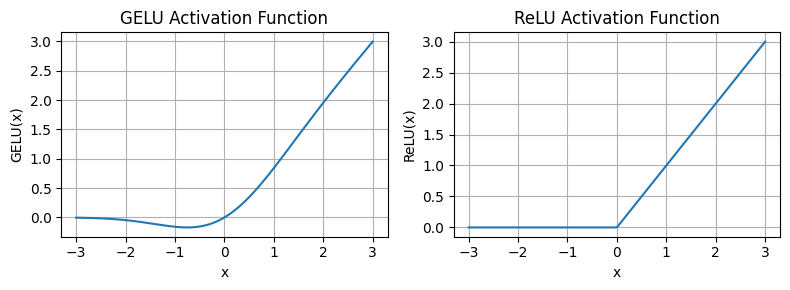

In [52]:
import torch, math
import torch.nn as nn
import matplotlib.pyplot as plt

# GELU (tanh approximation)
class GELU(nn.Module):
    def forward(self, x):
        c = math.sqrt(2.0 / math.pi)
        return 0.5 * x * (1 + torch.tanh(c * (x + 0.044715 * x**3)))

gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, steps=200)
y_gelu = gelu(x)
y_relu = relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ['GELU', 'ReLU']), start=1):
    plt.subplot(1, 2, i)
    # Avoid NumPy: pass Python lists to matplotlib
    plt.plot(x.detach().cpu().tolist(), y.detach().cpu().tolist())
    plt.title(f'{label} Activation Function')
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()


In [53]:
# Use GELU function to implement a feed forward network
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        # Creates a sequence of layers that make up the feed forward block
        self.layers = nn.Sequential(
            nn.Linear(cfg['embed_dim'], cfg['embed_dim'] * 4),
            GELU(),
            nn.Linear(cfg['embed_dim'] * 4, cfg['embed_dim']),
        )
    
    # Passsses the input through the feed forward layers
    def forward(self, x):
        return self.layers(x)


In [54]:
ffn = FeedForward(GPT_CONFIG_124)
x = torch.rand(2,3,768)
out_ffn = ffn(x)
print("Feed Forward Network Output Shape:", out_ffn.shape)

# The FeedForwards module plays a crucial role in enhancing the model's ability
# to learn from and generalize the data

Feed Forward Network Output Shape: torch.Size([2, 3, 768])


### Adding Shortcut Connections

- Were proposed for deep networks in computer vision to mitigate the challenge of vanishing gradients
- The vanishing gradient problem refers to the issue where gradients (which guid weight updates during training) become progressively smaller as they propagate backward through the layers, making it difficult to effectively train earlier layers

![](pic4.png)

- Shortcut connection creates an alternative, shorter path for the gradient to flow through the network by skipping one or more layers, which is achieved by adding the output of one layer to the output of a later layer


In [68]:
# Custom deep feedforward neural network implementation with optimal residual connections

class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),
        ])
    
    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output  # Add shortcut connection
            else:
                x = layer_output

        return x

In [69]:
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

In [72]:
# Implement a function that computes the gradients in the model's backward pass

def print_gradients(model,x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"Gradient for {name} has gradient mean of {param.grad.mean().item()}")

In [73]:
print_gradients(model_without_shortcut, sample_input)

Gradient for layers.0.0.weight has gradient mean of 6.4675179274609196e-12
Gradient for layers.1.0.weight has gradient mean of -8.115144009934738e-05
Gradient for layers.2.0.weight has gradient mean of -0.0011454185005277395
Gradient for layers.3.0.weight has gradient mean of 0.0027977479621767998
Gradient for layers.4.0.weight has gradient mean of 0.0013724254677072167


In [74]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)


Gradient for layers.0.0.weight has gradient mean of -1.6556845894299954e-09
Gradient for layers.1.0.weight has gradient mean of 0.007602863013744354
Gradient for layers.2.0.weight has gradient mean of -0.008172199130058289
Gradient for layers.3.0.weight has gradient mean of 0.11819545179605484
Gradient for layers.4.0.weight has gradient mean of 0.8907492756843567


### Connecting Attention and Linear Layers in a Transformer Block

- Implement the transformer block, a fundamental building block of GPT and other LLM architectures
- This block, which is repeated a dozen times in the 124-million-parameter GPT-2 architecture, combines with multi-head attention, layer normalization, dropout, feed forward layers, and GELU activations
- After creating the transformer block, we will be connecting it back to the remaining parts of the GPT architecture


**Transformer Block:** The Thinking Layer
- Is the core layer used in models like BERT and GPT
- Each block takes a sequence of token embeddings and return a sequence of the same shape, after mixing information across positions and passing it through a small MLP

In [ ]:
# Import from chapter 3


class MultiHeadAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias =False):
        # Calls the constructor of the parent class nn.Module
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Dimension of each attention head -> features per head
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        # Contain the combined results from all attention heads
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # Reshape to (batch_size, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1,2)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1,2)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1,2)

        attn_scores = queries @ keys.transpose(2,3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)
        attn_weights = torch.softmax(attn_scores / self.head_dim**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vecs = attn_weights @ values

        context_vecs = context_vecs.transpose(1,2).contiguous().view(b, num_tokens, self.d_out)
        output = self.out_proj(context_vecs)
        return output


In [79]:
# Each block handles self-attention, feed forward layers, layer normalization, dropout, and residual connections
# MLP: Multi-Layer Perceptron - a small feed-forward neural network: A stack of fully connected
# linear layers with non linear activations in between

class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()

        # Creates a multi-head attention layer that allows the model to "look at" different parts of the input sequence simultaneously
        # All parameters are derived from the cfg dictionary
        # It outputs representations of tokens that have contextual meaning
        self.att = MultiHeadAttention_v2(
            d_in=cfg['embed_dim'],
            d_out=cfg['embed_dim'],
            context_length=cfg['context_length'],
            dropout=cfg['dropout'],
            num_heads=cfg['n_heads'],
            qkv_bias=cfg['qkv_bias']
        )

        # Feed forward and Normalization layers
        self.ff = FeedForward(cfg) # A simple MLP applied to each token after attention
        self.norm1 = LayerNorm(cfg['embed_dim']) # Normalizes features to stabilize training
        self.norm2 = LayerNorm(cfg['embed_dim'])
        self.dropout = nn.Dropout(cfg['dropout']) # Regularization to prevent overfitting
    
    def forward(self, x):

        # Self-attention sub-layer with residual connection
        # 1. Save the input for the residual connection
        # 2. Normalaize it -> pass it through attention to get attention weights
        # 3. Apply dropout for regularization
        # 4. Add the original input (shortcut) back to the output of attention

        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.dropout(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x + shortcut
        return x

In [80]:
# Testing transformer block
torch.manual_seed(123)
x = torch.rand(2,4,768)
print(x)

block = TransformerBlock(GPT_CONFIG_124)
out_block = block(x)

print("Input shape:", x.shape)
print("Output shape:", out_block.shape)
print(out_block)

tensor([[[0.2961, 0.5166, 0.2517,  ..., 0.9541, 0.8567, 0.4604],
         [0.2238, 0.3047, 0.3019,  ..., 0.5465, 0.4532, 0.7598],
         [0.6945, 0.2478, 0.4111,  ..., 0.8838, 0.4898, 0.5963],
         [0.0890, 0.7804, 0.9223,  ..., 0.4507, 0.6357, 0.5833]],

        [[0.5716, 0.9297, 0.3396,  ..., 0.0477, 0.4564, 0.2797],
         [0.0936, 0.2211, 0.3806,  ..., 0.3948, 0.4545, 0.4536],
         [0.6788, 0.1741, 0.2084,  ..., 0.5557, 0.5930, 0.0959],
         [0.3894, 0.4083, 0.0662,  ..., 0.9861, 0.9341, 0.1319]]])
Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])
tensor([[[-0.0053,  0.0976, -0.1119,  ...,  1.2888,  0.2626,  0.6683],
         [ 0.0028, -0.2366,  0.1721,  ...,  0.5953,  0.2498,  0.7447],
         [ 0.4675,  0.4470,  0.1792,  ...,  1.2521,  0.3048,  0.7748],
         [ 0.0664,  0.7225,  0.9206,  ...,  0.4790,  0.7428,  0.7014]],

        [[ 0.3623,  1.2142,  0.5221,  ...,  0.1853,  0.0114, -0.5029],
         [-0.0224,  0.7787,  0.2769,  ...,  

### Assemble Everything into the GPT Model
![](pic5.png)

In [82]:
class GPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['embed_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['embed_dim'])
        self.drop = nn.Dropout(cfg['dropout'])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )

        self.final_norm = LayerNorm(cfg['embed_dim'])
        self.out_head = nn.Linear(cfg['embed_dim'], cfg['vocab_size'], bias=False)
    
    def forward(self, in_idx):
        batch_size, seq_length = in_idx.shape

        tok_embeddings = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_length, device=in_idx.device))

        x = self.drop(tok_embeddings + pos_embeds)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [83]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124)
logits = model(batch)
print(batch)

# For every position in each sequence, the model outputs a vector of length 50257 (one score per vocab token) predicting the next token at that position
# The values are unomralized scores --> Higher logits => higher predicted probability after softmax
print("Logits shape:", logits.shape)
print(logits)

tensor([[15496,   703,   389,   345],
        [  464,  2068,  7586, 21831]])
Logits shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1716, -0.0959,  0.2765,  ..., -0.1463,  0.4959, -0.4830],
         [-0.2893, -0.4382, -0.3006,  ...,  0.7259,  0.1451, -0.4303],
         [ 0.6534,  0.1764, -0.0896,  ..., -0.0177, -0.0242, -0.1244],
         [-0.8355,  0.4110, -0.1856,  ...,  0.7248,  0.3003, -0.1707]],

        [[-0.9079, -0.6797, -0.3012,  ...,  0.5028,  0.4142, -0.9061],
         [-0.2225,  0.0552, -0.1529,  ..., -0.4726, -0.1914,  0.0856],
         [ 0.9021,  0.1483,  0.0919,  ...,  0.6109, -0.7892, -0.3287],
         [-0.6954, -0.3157, -0.4043,  ...,  0.5993, -0.2863,  0.0094]]],
       grad_fn=<UnsafeViewBackward0>)


### Generating Text
![](pic6.png)

In [87]:

# Model: GPTModel
# idx: input token IDs
# max_new_tokens: number of new tokens to generate
# context_size: maximum context size for the model

def generate_text(model,idx,max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]  # Crop context if needed

        # Feed the current sequence to the model to get predictions for the next token
        # torch.no_grad(): disables gradient calculation to save memory and computation during inference
        with torch.no_grad():
            logits = model(idx_cond)
    
        # We only care about the logits of the last token position, because that's the model's prediction for the next token
        logits = logits[:, -1, :]  # Focus on the last token's logits
        probabilities = torch.softmax(logits, dim=-1)  # Convert logits to probabilities
        next_token = torch.multinomial(probabilities, num_samples=1)  # Sample the next token -> can use torch.argmax 
        idx = torch.cat((idx, next_token), dim=1)  # Append the sampled token to the sequence
    return idx

In [91]:
start_context = "Hello, I am"
enconded = tokenizer.encode(start_context)
print("Encoded start context:", enconded)

encoded_tensor = torch.tensor(enconded).unsqueeze(0)  # Add batch dimension
print("Encoded tensor shape:", encoded_tensor.shape)

Encoded start context: [15496, 11, 314, 716]
Encoded tensor shape: torch.Size([1, 4])


In [96]:
model.eval()  # Set the model to evaluation mode
out = generate_text(model = model
                    ,idx = encoded_tensor,
                    max_new_tokens = 6,
                    context_size = GPT_CONFIG_124['context_length'])

print("Generated token IDs:", out)
print("Output Length:", len(out[0]))

Generated token IDs: tensor([[15496,    11,   314,   716,  8164, 44896, 26923, 40578, 16352, 44297]])
Output Length: 10


In [97]:
decoded_output = tokenizer.decode(out.squeeze(0).tolist())
print("Generated Text:", decoded_output)

Generated Text: Hello, I amClick furiously Connectionposted riot Dek
